# IMPORTANDO BIBLIOTECAS

In [63]:
# Importando bibliotecas necessárias
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression


# EXIBIÇÃO DOS DATAFRAMES

In [2]:
# Configurando a exibição do dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 30)

# LEITURA DOS ARQUIVOS

In [3]:
# Lista com caminhos locais distintos
diretorios_locais = [
    r'C:\Users\brand\OneDrive\Área de Trabalho\Fraud_Detection_ML\Data\\',
    r'C:\Users\Giovanni Maia\Desktop\Dados\\'
]

diretorio_github= 'https://media.githubusercontent.com/media/jeanbrandao01/Fraud_Detection_ML/dev/Data/'

def carregar_dataframes(diretorios_locais, diretorio_github):
    for diretorio_local in diretorios_locais:
        try:
            # Tente carregar o DataFrame de fraudTest.csv a partir do diretório local
            df_test = pd.read_csv(diretorio_local + 'fraudTest.csv')

            # Tente carregar o DataFrame de fraudTrain.csv a partir do diretório local
            df_train = pd.read_csv(diretorio_local + 'fraudTrain.csv')

            # Se o carregamento for bem-sucedido, retorne os DataFrames
            return df_test, df_train
        except FileNotFoundError:
            continue  # Continue para o próximo diretório local em caso de erro

    # Se nenhum diretório local contiver os arquivos, carregue do GitHub
    url_test = diretorio_github + 'fraudTest.csv'
    url_train = diretorio_github + 'fraudTrain.csv'

    df_test = pd.read_csv(url_test)
    df_train = pd.read_csv(url_train)

    return df_test, df_train

df_test, df_train = carregar_dataframes(diretorios_locais,diretorio_github)


# EXIBIÇÃO DOS DATAFRAMES ORIGINAIS

In [4]:
# Dataframe "fraudTest.csv"
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
# Dataframe "fraudTrain.csv"
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# ANÁLISE DESCRITIVA: DATASET DE TREINO - FRAUDTRAIN.CSV

In [6]:
# Algumas estatisticas do dataset
df_train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [7]:
# Verificando as colunas existentes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
# Realizando a contagem de valores da coluna "merchant"
df_train.merchant.value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

In [9]:
# Realizando a contagem de valores da coluna "is_fraud"
print("Contagem de valores da coluna is_fraud:")
print("-"*39)
print(df_train.is_fraud.value_counts())


Contagem de valores da coluna is_fraud:
---------------------------------------
is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [10]:
# Verificando a extensão do dataset
print("Extensão do dataset:")
print("-"*23)
print(df_train.shape)


Extensão do dataset:
-----------------------
(1296675, 23)


In [11]:
# Verificando os nomes de cada coluna 
print("Colunas do dataset")
print(df_train.columns)

Colunas do dataset
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


# ANÁLISE EXPLORATÓRIA: DATASET DE TREINO - FRAUDTRAIN.CSV

In [12]:
# Calcular a proporção de fraudes
fraud_proportion = df_train['is_fraud'].value_counts(normalize=True)

# Criar um DataFrame para facilitar a criação do gráfico
fraud_data = pd.DataFrame({'Classe de Fraude': fraud_proportion.index, 'Proporção': fraud_proportion.values})

# Criar o gráfico de barras com o Plotly
fig = px.bar(fraud_data, x='Classe de Fraude', y='Proporção', text='Proporção', title='Distribuição de Fraudes', labels={'Classe de Fraude': 'Classe de Fraude'})
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()



In [13]:
# mostrando a porcentagem de transações fraudulentas e não fraudulentas para cada categoria presente na coluna category 
round(pd.crosstab(index=df_train.category, columns=df_train.is_fraud, normalize='index')*100,2)

is_fraud,0,1
category,,
entertainment,99.75,0.25
food_dining,99.83,0.17
gas_transport,99.53,0.47
grocery_net,99.71,0.29
grocery_pos,98.59,1.41
health_fitness,99.85,0.15
home,99.84,0.16
kids_pets,99.79,0.21
misc_net,98.55,1.45


In [14]:
# Cria uma tabela de contingência
crosstab = pd.crosstab(index=df_train.category, columns=df_train.is_fraud, normalize='index') * 100

# Reinicia o índice para facilitar o manuseio
crosstab = crosstab.reset_index()

# Cria um gráfico de barras empilhadas usando o Plotly Express
fig = px.bar(crosstab, x='category', y=[0, 1], title="Gráfico de Barras Empilhadas da Tabela de Contingência (Percentual)",
             labels={0: "Não Fraude", 1: "Fraude"},
             height=400)

# Atualiza o layout para um gráfico de barras empilhadas
fig.update_layout(barmode='stack')

# Mostra o gráfico
fig.show()


## Fraudes por estado

In [15]:
# Retorna o número de estados únicos presentes na coluna state
df_train.state.nunique()

51

In [16]:
# Agrupa os dados por estado e calcula o número total de transações em cada estado
total_transacoes_por_estado = df_train["state"].value_counts()

# Filtra os dados para transações fraudulentas
dados_fraudulentos = df_train[df_train["is_fraud"] == 1]

# Agrupa os dados fraudulentos por estado e calcula o número de transações fraudulentas em cada estado
transacoes_fraudulentas_por_estado = dados_fraudulentos["state"].value_counts()

# Calcula a taxa de fraude para cada estado (transações fraudulentas / total de transações)
taxa_de_fraude = (transacoes_fraudulentas_por_estado / total_transacoes_por_estado).fillna(0)

# Reinicia o índice e ordena os resultados por 'count' de forma descendente
taxa_de_fraude.reset_index().sort_values(by='count', ascending=False)


,state,count
8,DE,1.000000
39,RI,0.027273
0,AK,0.016981
33,NV,0.008382
5,CO,0.008141
...,...,...
3,AZ,0.003435
11,HI,0.002735
26,MT,0.002722
6,CT,0.002077


In [17]:
# Retorna as últimas 20 linhas (estados) dessa Series, representando os estados com o menor número de transações. 
total_transacoes_por_estado.tail(20)

state
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV     5607
ID     5545
DC     3613
HI     2559
AK     2120
RI      550
DE        9
Name: count, dtype: int64

## Fraudes por cidade

In [18]:
# Retorna o número de cidades únicas presentes na coluna cidade
df_train.city.nunique()

894

In [19]:
# Agrupa os dados por cidade e calcula o número total de transações em cada cidade
total_transacoes_por_cidade = df_train["city"].value_counts()

# Filtra os dados para transações fraudulentas
dados_fraudulentos = df_train[df_train["is_fraud"] == 1]

# Agrupa os dados fraudulentos por cidade e calcula o número de transações fraudulentas em cada cidade
transacoes_fraudulentas_por_cidade = dados_fraudulentos["city"].value_counts()

# Calcula a taxa de fraude para cada cidade (transações fraudulentas / total de transações)
taxa_de_fraude = (transacoes_fraudulentas_por_cidade / total_transacoes_por_cidade).fillna(0)

# Seleciona as cidades com taxa de fraude igual a 1, reinicia o índice e ordena os resultados por 'count' de forma descendente
taxa_de_fraude[taxa_de_fraude == 1].reset_index().sort_values(by='count', ascending=False)


,city,count
0,Angwin,1.0
43,Orange Park,1.0
31,Melville,1.0
32,Mineral,1.0
33,Morven,1.0
...,...,...
23,Kaktovik,1.0
24,Karns City,1.0
25,La Grande,1.0
26,Las Vegas,1.0


## Boxplot do valor da compra por classe

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


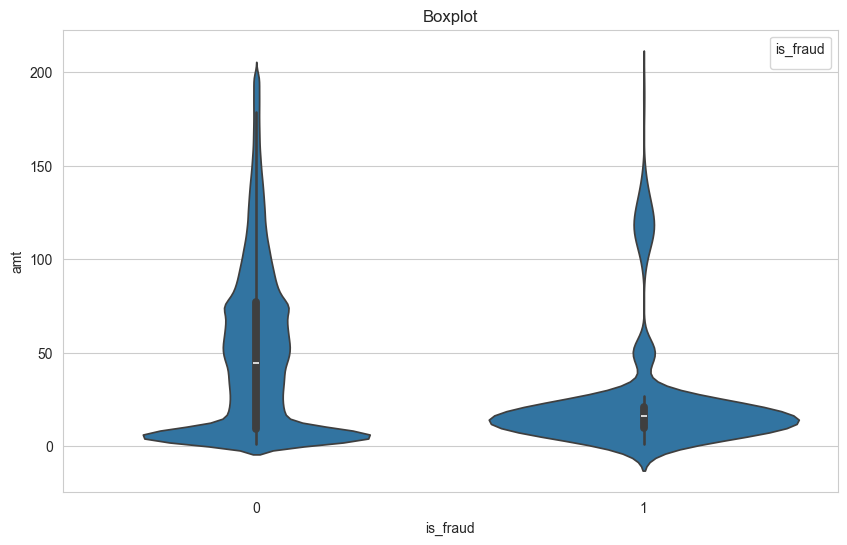

In [20]:
# Define o estilo (opcional)
sns.set_style("whitegrid")

# Cria um histograma com KDE usando o Seaborn
plt.figure(figsize=(10, 6))  # Define o tamanho da figura (opcional)
sns.violinplot(data=df_train.query('amt <= 200'), x='is_fraud', y='amt')

# Define o título e rótulos
plt.title('Boxplot')
plt.xlabel('is_fraud')
plt.ylabel('amt')

# Mostra a legenda (opcional)
plt.legend(title='is_fraud')

# Mostra o gráfico
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


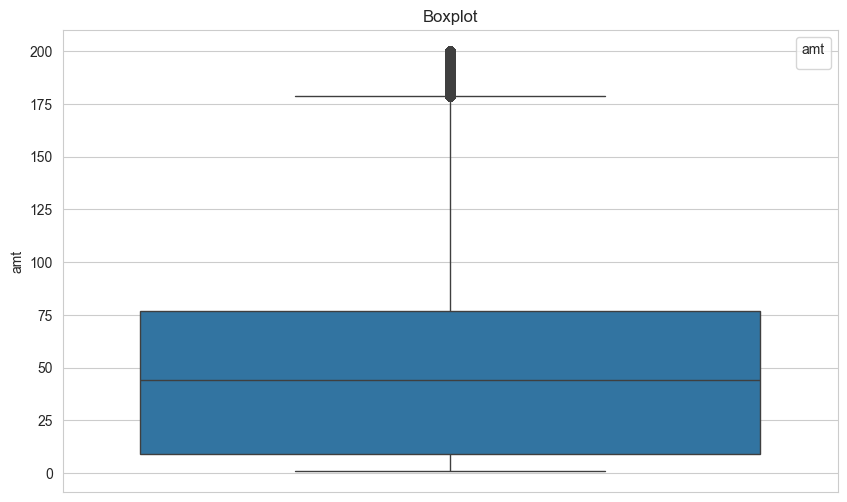

In [21]:
# Define o estilo (opcional)
sns.set_style("whitegrid")

# Cria um boxplot usando o Seaborn
plt.figure(figsize=(10, 6))  # Define o tamanho da figura (opcional)
sns.boxplot(data=df_train.query('amt <= 200'), y='amt')

# Define o título e rótulos
plt.title('Boxplot')
plt.ylabel('amt')

# Mostra a legenda (opcional)
plt.legend(title='amt')

# Mostra o gráfico
plt.show()


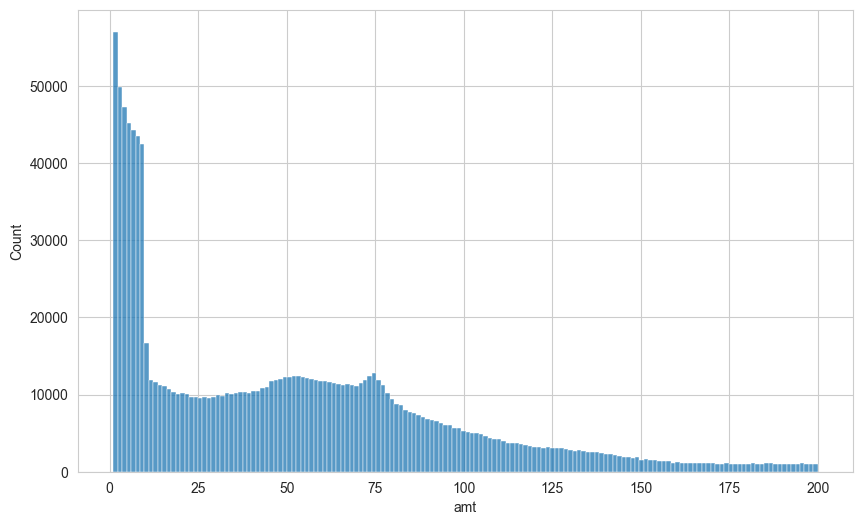

In [22]:
# Define o estilo (opcional)
sns.set_style("whitegrid")

# Cria um histograma com KDE usando o Seaborn
plt.figure(figsize=(10, 6))  # Define o tamanho da figura (opcional)
sns.histplot(data=df_train.query('amt <= 200'), x='amt')

# Mostra o gráfico
plt.show()


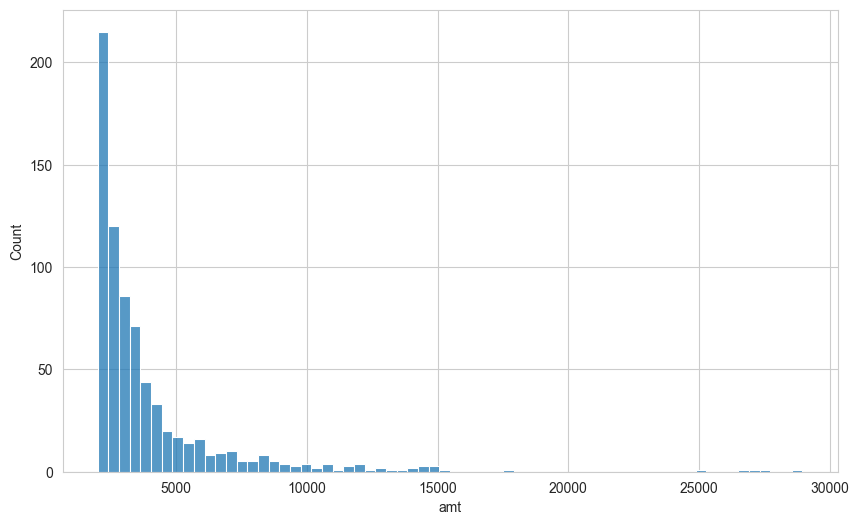

In [23]:
# Define o estilo (opcional)
sns.set_style("whitegrid")

# Cria um histograma com KDE usando o Seaborn
plt.figure(figsize=(10, 6))  # Define o tamanho da figura (opcional)
sns.histplot(data=df_train.query('amt > 2000'), x='amt')

# Mostra o gráfico
plt.show()


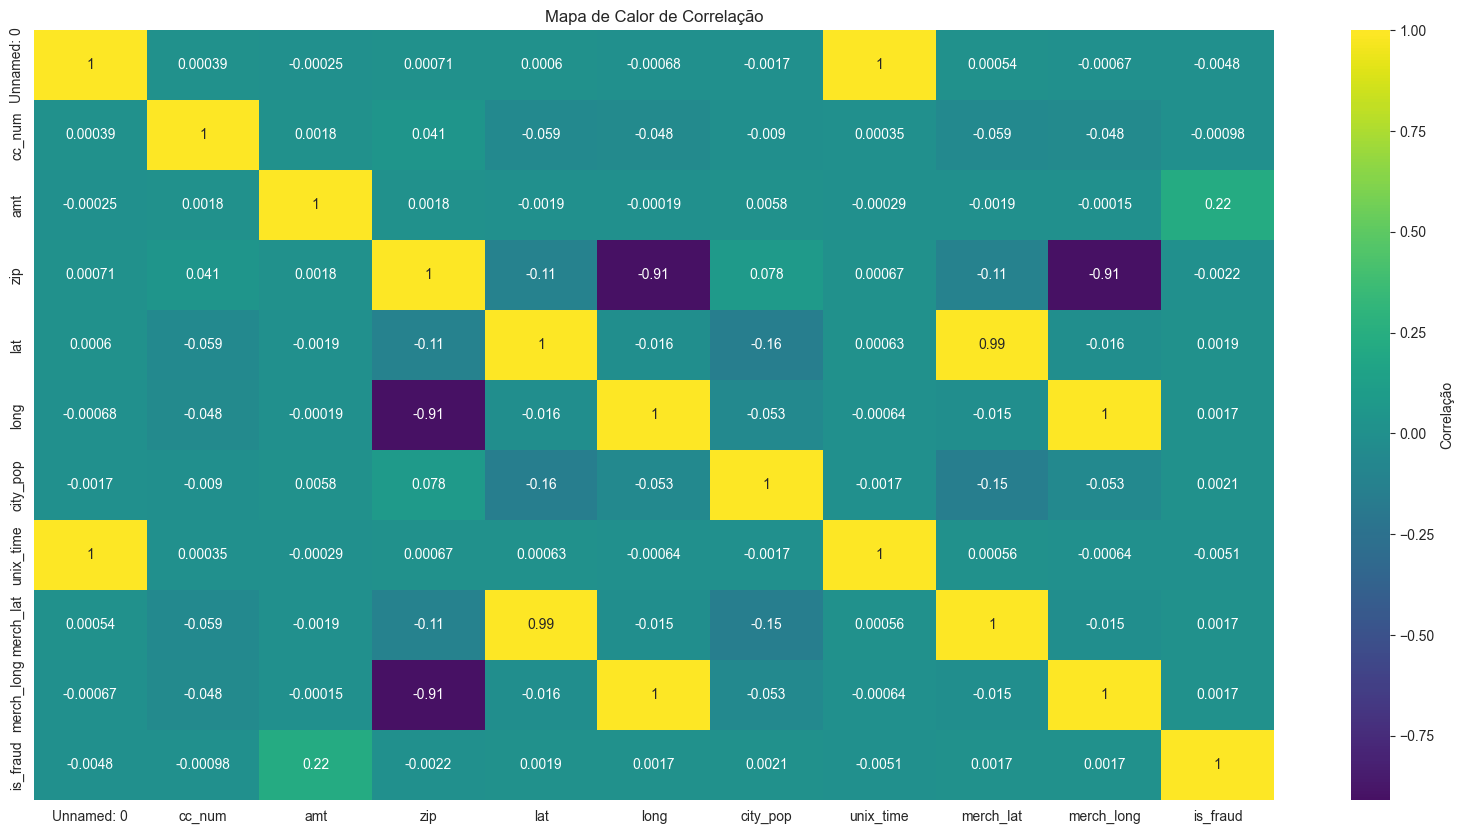

In [24]:
# Selecionar apenas as colunas numéricas
numeric_columns = df_train.select_dtypes(include=['int64', 'float64'])

# Calculando a matriz de correlação para colunas numéricas
correlation_matrix = numeric_columns.corr()

# Criando uma figura maior
plt.figure(figsize=(20, 10))

# Criando um mapa de calor de correlação com paleta de cores personalizada
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Mapa de Calor de Correlação')

plt.show()


In [25]:
# Análise temporal

# Convertendo a coluna 'trans_date_trans_time' para um objeto de data e hora
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])

# Extraindo características de data e hora
df_train['ano'] = df_train['trans_date_trans_time'].dt.year
df_train['mes'] = df_train['trans_date_trans_time'].dt.month
df_train['dia_da_semana'] = df_train['trans_date_trans_time'].dt.day_name()
df_train['hora'] = df_train['trans_date_trans_time'].dt.hour

# Filtrando fraudes
frauds = df_train[df_train['is_fraud'] == 1]

# Contando fraudes por mês
frauds_by_month = frauds['mes'].value_counts().sort_index().reset_index()
frauds_by_month.columns = ['Mês', 'Número de Fraudes']

# Criando um gráfico de barras interativo com Plotly
fig = px.bar(frauds_by_month, x='Mês', y='Número de Fraudes', title='Fraudes por Mês',
             labels={'Mês': 'Mês', 'Número de Fraudes': 'Número de Fraudes'})

# Adicionando números em cima das barras
fig.update_traces(text=frauds_by_month['Número de Fraudes'], textposition='outside')

fig.show()


In [26]:
# Contagem de ocorrências por categoria
category_counts = df_train['category'].value_counts().reset_index()
category_counts.columns = ['Categoria', 'Contagem']

# Agrupando por categoria e calculando a proporção de fraudes
fraud_proportion_by_category = df_train.groupby('category')['is_fraud'].mean().reset_index()
fraud_proportion_by_category.columns = ['Categoria', 'Proporção de Fraudes']

# Criando um gráfico de barras interativo com Plotly
fig = px.bar(fraud_proportion_by_category, x='Categoria', y='Proporção de Fraudes', title='Proporção de Fraudes por Categoria',
             labels={'Categoria': 'Categoria', 'Proporção de Fraudes': 'Proporção de Fraudes'})

# Formatando os números com cinco casas decimais
fraud_proportion_by_category['Proporção de Fraudes'] = fraud_proportion_by_category['Proporção de Fraudes'].round(5)

# Adicionando os números formatados (com cinco casas decimais) em cima das barras
fig.update_traces(text=fraud_proportion_by_category['Proporção de Fraudes'], textposition='outside')

fig.show()


# FEATURE ENGINEERING

In [27]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,ano,mes,dia_da_semana,hora
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,1,Tuesday,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1,Tuesday,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,1,Tuesday,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,1,Tuesday,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,1,Tuesday,0


In [41]:
# Defina o DataFrame inicial
df_train = df_train[['amt', 'category', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'ano', 'mes', 'dia_da_semana', 'hora', 'is_fraud']].copy()

In [29]:
# Preparação dos dados e divisão em treino/teste
features = df_train[['amt', 'category', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'unix_time', 'merch_lat', 'merch_long', 'ano', 'mes', 'dia_da_semana', 'hora']]
labels = df_train['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)


In [30]:
# Definição de transformadores para Pré-processamento
numericas_continuas = ['amt', 'zip', 'lat', 'long', 'unix_time', 'merch_lat', 'merch_long', 'ano', 'mes', 'hora']
string_categoricas = ['category', 'gender', 'city', 'state', 'dia_da_semana']

# Transformadores para variáveis numéricas contínuas
numeric_transformer = StandardScaler()

# Transformadores para variáveis categóricas
categorical_transformer = OneHotEncoder()

# Lista de tuplas indicando os transformadores a serem aplicados a cada conjunto de features
transformers = [
    ('num_continuas', numeric_transformer, numericas_continuas),
    ('str_categoricas', categorical_transformer, string_categoricas)
]

# Criação do ColumnTransformer integrado ao Pipeline
preprocessor = ColumnTransformer(transformers=transformers)


In [31]:
# Treinamento do pré-processador
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [32]:
# Lista de classificadores
classifiers_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]


In [33]:
# Função para treinar, avaliar e prever para cada classificador
def train_evaluate_and_predict(classifier, X_train_transformed, y_train, X_test_transformed, y_test):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_transformed, y_train)
    y_pred = pipe.predict(X_test_transformed)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        "Classifier": classifier.__class__.__name__,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Predictions": y_pred
    }


In [34]:
# Execução em paralelo para todos os classificadores
results = Parallel(n_jobs=-1)(
    delayed(train_evaluate_and_predict)(
        classifier, X_train_transformed, y_train, X_test_transformed, y_test
    ) for classifier in classifiers_list
)


In [44]:
# Criação do DataFrame final
df_predictions = pd.DataFrame(df_train)  # Copiando o DataFrame original

# Adição das previsões ao DataFrame final
for result in results:
    classifier_name = result["Classifier"]
    predictions = result["Predictions"]
    
    # Ajuste para garantir que o número de previsões corresponda ao número de linhas no DataFrame original
    if len(predictions) != len(df_predictions):
        predictions = [0] * (len(df_predictions) - len(predictions)) + list(predictions)

    df_predictions[f"{classifier_name}_Prediction"] = predictions


In [46]:
df_predictions[df_predictions['is_fraud'] == 1]

,amt,category,gender,city,state,zip,lat,long,dob,unix_time,merch_lat,merch_long,ano,mes,dia_da_semana,hora,is_fraud,LogisticRegression_Prediction,DecisionTreeClassifier_Prediction,RandomForestClassifier_Prediction,AdaBoostClassifier_Prediction,GradientBoostingClassifier_Prediction
2449,281.06,grocery_pos,M,Collettsville,NC,28611,35.9946,-81.7266,1988-09-15,1325466397,36.430124,-81.179483,2019,1,Wednesday,1,1,0,0,0,0,0
2472,11.52,gas_transport,F,San Antonio,TX,78208,29.4400,-98.4590,1960-10-28,1325468849,29.819364,-99.142791,2019,1,Wednesday,1,1,0,0,0,0,0
2523,276.31,grocery_pos,F,San Antonio,TX,78208,29.4400,-98.4590,1960-10-28,1325473523,29.273085,-98.836360,2019,1,Wednesday,3,1,0,0,0,0,0
2546,7.03,gas_transport,M,Collettsville,NC,28611,35.9946,-81.7266,1988-09-15,1325475483,35.909292,-82.091010,2019,1,Wednesday,3,1,0,0,0,0,0
2553,275.73,grocery_pos,F,San Antonio,TX,78208,29.4400,-98.4590,1960-10-28,1325476547,29.786426,-98.683410,2019,1,Wednesday,3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,977.01,shopping_net,F,Vero Beach,FL,32960,27.6330,-80.4031,1986-05-07,1371776408,26.888686,-80.834389,2020,6,Sunday,1,1,0,0,0,0,0
1295491,1210.91,shopping_net,F,Vero Beach,FL,32960,27.6330,-80.4031,1986-05-07,1371779615,28.216707,-79.855648,2020,6,Sunday,1,1,0,0,0,0,0
1295532,10.24,gas_transport,M,Denham Springs,LA,70726,30.4590,-90.9027,1994-05-31,1371781016,29.700456,-91.361632,2020,6,Sunday,2,1,0,0,0,0,0
1295666,21.69,gas_transport,F,Notrees,TX,79759,31.8599,-102.7413,1969-09-15,1371785180,32.675272,-103.484949,2020,6,Sunday,3,1,0,0,0,0,0


In [62]:
def create_confusion_matrix_heatmap(title, true_labels, predicted_labels, width=500, height=400, margin_top=50):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    heatmap = ff.create_annotated_heatmap(
        z=conf_matrix,
        x=['Not Fraud', 'Fraud'],
        y=['Not Fraud', 'Fraud'],
        colorscale='Blues',
        showscale=False
    )

    layout_settings = dict(
        xaxis=dict(title='Predicted', tickvals=[0.5, 1.5], ticktext=['Not Fraud', 'Fraud']),
        yaxis=dict(title='True', tickvals=[0.5, 1.5], ticktext=['Not Fraud', 'Fraud']),
        width=width,
        height=height,
        margin=dict(t=margin_top),
    )

    heatmap.update_layout(**layout_settings, title=title)
    return heatmap

prediction_columns = [
    'LogisticRegression_Prediction',
    'DecisionTreeClassifier_Prediction',
    'RandomForestClassifier_Prediction',
    'AdaBoostClassifier_Prediction',
    'GradientBoostingClassifier_Prediction'
]

for classifier_column in prediction_columns:
    heatmap = create_confusion_matrix_heatmap(
        title=f'is_fraud vs. {classifier_column}',
        true_labels=df_predictions['is_fraud'],
        predicted_labels=df_predictions[classifier_column]
    )
    heatmap.show()


In [36]:
# NAO ESQUECER DE COLOCAR A SEED DA ADEQUAÇÃO DO MODELO JEAN